# Models traning on RPW Dataset

This notebook compares the performance of MobileNetV3, EfficientNetB0 and EfficientNetB4 models on a custom image classification dataset. The implementation is RAM-optimized by loading all images into memory at the start, which can significantly speed up training when working with smaller datasets.

## Overview
- We'll use transfer learning with pre-trained models
- The models will be partially frozen to preserve low-level features
- Custom classifiers will be added to adapt to our binary classification task
- Performance metrics will be evaluated and visualized

## 1- Setting Up the Environment

First, let's import all necessary libraries and set up our device configuration.

In [1]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.models import (
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights,
    efficientnet_b4,
    EfficientNet_B4_Weights,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns

# Device config - will use CUDA if available, Apple Metal if available, otherwise CPU
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print("Using device:", device)
use_amp = device.type == "cuda"  # Only use AMP with CUDA
scaler = GradScaler("cuda", enabled=use_amp)

Using device: mps


Seting up a seed for reproduceability

In [2]:
seed = 42
# Set seed for reproducibility
torch.manual_seed(seed)

Configuring the models to be used

In [35]:
MODEL_CONFIGS = {
    "mobilenet": {
        "builder": mobilenet_v3_large,
        "weights": MobileNet_V3_Large_Weights.DEFAULT,
        "classifier_index": 0,
        "input_size": 90,
    },
    "efficientnet_b0": {
        "builder": efficientnet_b0,
        "weights": EfficientNet_B0_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 90,
    },
    "efficientnet_b4": {
        "builder": efficientnet_b4,
        "weights": EfficientNet_B4_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 90,
    },
}

## 2- Dataset Implementation

Our `InMemoryDataset` class loads all images into RAM at initialization. This approach trades memory for speed, which is beneficial for smaller datasets as it eliminates disk I/O during training.

In [4]:
class InMemoryDataset(Dataset):
    """
    A custom dataset class that loads images and their corresponding labels into memory.

    Args:
        root_dir (str): The root directory where the image folders are located.
        transform (callable, optional): A function/transform to apply to the images (default is None).

    Attributes:
        data (list): A list of transformed images.
        labels (list): A list of corresponding labels for each image.
        class_to_idx (dict): A dictionary mapping class names to numeric labels.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns the image and its label at the specified index.
    """

    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []

        class_dirs = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_dirs)}

        for cls_name in class_dirs:
            cls_path = os.path.join(root_dir, cls_name)
            img_paths = glob.glob(os.path.join(cls_path, "*.*"))
            for path in img_paths:
                try:
                    img = Image.open(path).convert("RGB")
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(self.class_to_idx[cls_name])
                except Exception as e:
                    print(f"Skipping image {path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

## 3- Model Building Functions

We'll define functions for:
1. Partial freezing of model layers to leverage pre-trained weights
2. Building the model architecture with custom classifier heads

### Function for partial layer freezing

In [5]:
def freeze_partial(model, freeze_ratio=0.9):
    """
    Freezes a proportion of the early layers of a model.

    Args:
        model (nn.Module): The model whose layers will be partially frozen.
        freeze_ratio (float, optional): The ratio of early layers to freeze.
                                        Default is 0.6 (60% of layers will be frozen).

    Modifies the model in place by setting the `requires_grad` attribute to False
    for the parameters of the frozen layers, preventing them from being updated during training.
    """
    # Get all layers of the model's features (assuming 'features' attribute is used)
    layers = list(model.features.children())

    # Calculate how many layers to freeze
    num_freeze = int(len(layers) * freeze_ratio)

    # Freeze the specified number of layers
    for i, layer in enumerate(layers):
        if i < num_freeze:
            for param in layer.parameters():
                param.requires_grad = False

### Function for bulding the model 

In [31]:
def build_model(model_name, num_classes=2, freeze_ratio=0.9):
    """
    Builds and returns a model based on the specified configuration.

    Args:
        model_name (str): The name of the model to build (e.g., 'resnet', 'vgg').
        num_classes (int, optional): The number of output classes for classification. Default is 2.
        freeze_ratio (float, optional): The ratio of layers to freeze. Default is 0.6 (60% of layers will be frozen).

    Returns:
        nn.Module: The modified model ready for training, with the specified number of output classes and frozen layers.

    Raises:
        ValueError: If the provided model_name is not supported.

    Modifications:
        - The model's classifier is updated to have a 512-unit hidden layer with ReLU activation and dropout.
        - A portion of the model's layers (defined by freeze_ratio) are frozen to prevent weight updates during training.
    """
    # Check if the model name is valid
    if model_name not in MODEL_CONFIGS:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Retrieve model configuration
    config = MODEL_CONFIGS[model_name]

    # Build the model with the corresponding weights
    model = config["builder"](weights=config["weights"])
    print(model.classifier) 

    # Update the classifier layer
    in_features = model.classifier[config["classifier_index"]].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )

    # Freeze early layers
    freeze_partial(model, freeze_ratio)

    return model.to(device)

## 4- Training and Evaluation Functions

Next, we'll define functions for:
1. Training the models with early stopping
2. Evaluating model performance with multiple metrics
3. Visualizing the training process and results

### Main function for training

In [7]:
from tqdm import tqdm

# Function to move the images and labels (if provided) to the specified device (CPU or CUDA)
def transfer_to_device(imgs, labels=None):
    """
    Transfers images and optional labels to the specified device (CPU or CUDA).

    Args:
        imgs (Tensor): The image batch to transfer to the device.
        labels (Tensor, optional): The corresponding labels to transfer. Default is None.

    Returns:
        Tuple: A tuple containing the transferred images and labels (if provided).
            - If `labels` is provided, returns (imgs, labels).
            - If `labels` is not provided, returns only imgs.

    This function utilizes the `non_blocking` argument for CUDA to speed up data transfer.
    """
    # Transfer images to the specified device
    imgs = imgs.to(device, non_blocking=(device.type == "cuda"))

    if labels is not None:
        # Transfer labels to the specified device, if provided
        labels = labels.to(device, non_blocking=(device.type == "cuda"))
        return imgs, labels

    return imgs

In [8]:
# Main Training loop
def train_model(model, train_loader, val_loader, epochs=10):
    """
    Trains and validates the given model over a specified number of epochs.

    Args:
        model (nn.Module): The neural network model to be trained.
        train_loader (DataLoader): The DataLoader for training data.
        val_loader (DataLoader): The DataLoader for validation data.
        epochs (int, optional): The number of epochs to train the model. Default is 10.

    Returns:
        Tuple: A tuple containing two lists:
            - train_loss_hist: The average training loss per epoch.
            - val_loss_hist: The average validation loss per epoch.

    The function performs the following tasks:
        - Performs forward and backward passes with loss computation.
        - Optimizes the model using the Adam optimizer.
        - Scales gradients for mixed precision training on CUDA (if available).
        - Tracks and prints the training and validation losses for each epoch.
    """
    criterion = nn.CrossEntropyLoss()  # Loss function
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005
    )  # Optimizer (Adam)
    scaler = torch.amp.GradScaler(
        enabled=(device.type == "cuda")
    )  # Gradient scaler for mixed precision

    train_loss_hist, val_loss_hist = [], []  # To store loss histories

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        # Training loop
        for imgs, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"
        ):
            imgs, labels = transfer_to_device(imgs, labels)  # Move data to device
            optimizer.zero_grad()  # Zero the gradients

            # Mixed precision forward pass
            with autocast(device_type=device.type, enabled=(device.type == "cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            # Backward pass and optimization
            if device.type == "cuda":
                scaler.scale(loss).backward()  # Backpropagate with scaling
                scaler.step(optimizer)  # Step optimizer
                scaler.update()  # Update scaler
            else:
                loss.backward()  # Regular backward pass for CPU
                optimizer.step()  # Step optimizer

            total_train_loss += loss.item()  # Accumulate training loss

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0

        # Validation loop
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"
            ):
                imgs, labels = transfer_to_device(imgs, labels)  # Move data to device

                # Mixed precision forward pass
                with autocast(device_type=device.type, enabled=(device.type == "cuda")):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()  # Accumulate validation loss

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_loss_hist.append(avg_train_loss)
        val_loss_hist.append(avg_val_loss)

        # Print the results for the current epoch
        print(
            f"[Epoch {epoch+1}] 🔹 Train Loss: {avg_train_loss:.4f} 🔸 Val Loss: {avg_val_loss:.4f}"
        )

    return train_loss_hist, val_loss_hist

### Evaluation function

In [9]:
def evaluate(model, test_loader, class_names=None, show_cm=True):
    """
    Evaluates the model's performance on the test set.

    Args:
        model (nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        class_names (list, optional): A list of class names for the target labels.
                                       If None, will infer from the dataset.
        show_cm (bool, optional): If True, displays a confusion matrix plot. Default is True.

    Returns:
        Tuple: A tuple containing the following evaluation metrics:
            - accuracy (float): The accuracy of the model on the test set.
            - precision (float): The precision of the model on the test set.
            - recall (float): The recall of the model on the test set.
            - f1 (float): The F1 score of the model on the test set.

    This function computes and prints:
        - Accuracy, Precision, Recall, and F1 Score
        - A classification report
        - Optionally, a confusion matrix
    """
    model.eval()  # Set the model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for imgs, labels in test_loader:
            imgs = imgs.to(device, non_blocking=(device.type == "cuda"))
            labels = labels.to(device, non_blocking=(device.type == "cuda"))

            outputs = model(imgs)
            preds = (
                torch.argmax(outputs, dim=1).cpu().numpy()
            )  # Get the predicted class
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())  # Collect all labels

    # Infer class names if not provided
    if (
        class_names is None
        and hasattr(test_loader.dataset, "dataset")
        and hasattr(test_loader.dataset.dataset, "classes")
    ):
        class_names = test_loader.dataset.dataset.classes

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Print the evaluation metrics
    print(f"\nEvaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Print the classification report
    print("\nClassification Report:")
    print(
        classification_report(
            all_labels, all_preds, target_names=class_names, zero_division=0
        )
    )

    # Confusion matrix
    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    return acc, prec, rec, f1

### Function to plot the loss

In [10]:
def plot_loss(train_loss, val_loss, title):
    """
    Plots the training and validation loss curves over epochs.

    Args:
        train_loss (list): A list of training loss values, one for each epoch.
        val_loss (list): A list of validation loss values, one for each epoch.
        title (str): The title of the plot.

    Displays:
        A plot with training and validation loss curves, showing how the losses change over epochs.
    """
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(train_loss, label="Train Loss", color="blue")  # Plot training loss
    plt.plot(val_loss, label="Val Loss", color="red")  # Plot validation loss
    plt.title(title)  # Set the plot title
    plt.xlabel("Epoch")  # X-axis label
    plt.ylabel("Loss")  # Y-axis label
    plt.legend()  # Show legend
    plt.grid(True)  # Show gridlines for better readability
    plt.show()  # Display the plot

## 5- Data Preparation

Let's set up our data transformations and loading function.

In [20]:
from torch.utils.data import Subset


def prepare_dataloaders(
    model_name, data_path="./data", batch_size=32, seed=seed, sample_size=None
):
    """
    Prepares the training, validation, and test data loaders from a given dataset.

    Args:
        model_name (str): The model name, used to retrieve the input image size from MODEL_CONFIGS.
        data_path (str, optional): The path to the dataset. Default is "./data".
        batch_size (int, optional): The batch size for the DataLoader. Default is 32.
        seed (int, optional): The seed for random splitting the dataset. Default is None.
        sample_size (int, optional): The number of samples to use for the dataset. If None, the full dataset is used. Default is None.

    Returns:
        tuple: A tuple containing the following elements:
            - train_loader (DataLoader): The data loader for the training dataset.
            - val_loader (DataLoader): The data loader for the validation dataset.
            - test_loader (DataLoader): The data loader for the test dataset.
            - class_names (list): A list of class names in the dataset.

    This function performs the following:
        - Applies image transformations (resize, normalization) to the dataset.
        - Optionally creates a subset of the dataset based on the sample_size.
        - Splits the dataset into training, validation, and test subsets.
        - Creates DataLoader instances for each subset.
        - Prints dataset size information and class names.
    """
    img_size = MODEL_CONFIGS[model_name]["input_size"]

    # Image preprocessing pipeline
    common_transforms = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Load dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=data_path, transform=common_transforms)
    # Save class names before creating the subset
    class_names = full_dataset.classes

    # Create a subset of the dataset (if sample_size is specified)
    if sample_size:
        # Randomly sample 'sample_size' number of images from the dataset
        indices = torch.randperm(len(full_dataset)).tolist()[:sample_size]
        full_dataset = Subset(full_dataset, indices)

    # Dataset split (70% training, 15% validation, 15% test)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Ensure reproducibility by using the provided seed
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size], generator=generator
    )

    # Create DataLoader instances for each dataset split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Info on dataset sizes and class names
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    print(f"Classes: {class_names}")

    return train_loader, val_loader, test_loader, class_names

## 6- Models

### 1.Train and Evaluate MobileNetV3

Now let's train our first model, MobileNetV3, and evaluate its performance.

Train dataset size: 700
Validation dataset size: 150
Test dataset size: 150
Classes: ['NRPW', 'RPW']

===== Training MobileNetV3 =====
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)


Epoch 1/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


[Epoch 1] 🔹 Train Loss: 0.4932 🔸 Val Loss: 0.6281


Epoch 2/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


[Epoch 2] 🔹 Train Loss: 0.1895 🔸 Val Loss: 0.4562


Epoch 3/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


[Epoch 3] 🔹 Train Loss: 0.0731 🔸 Val Loss: 0.6335


Epoch 4/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  7.40it/s]


[Epoch 4] 🔹 Train Loss: 0.0419 🔸 Val Loss: 0.5810


Epoch 5/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

[Epoch 5] 🔹 Train Loss: 0.0168 🔸 Val Loss: 0.3997


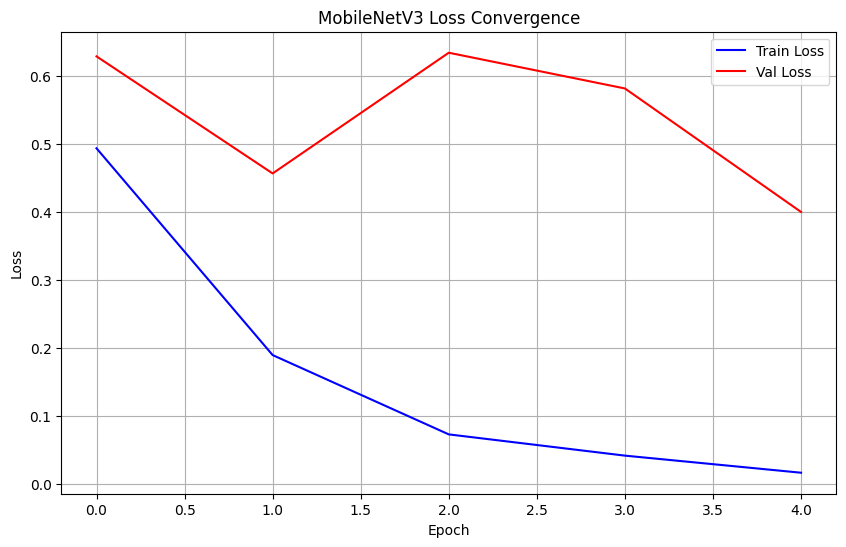

In [32]:
# Define model name
model_name = "mobilenet"

# Prepare dataloaders using model-specific image size
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name,sample_size=1000, batch_size=64)

# Train and evaluate
print("\n===== Training MobileNetV3 =====")
mobilenet_model = build_model(model_name)
mobile_train_loss, mobile_val_loss = train_model(
    mobilenet_model, train_loader, val_loader, epochs=5
)

plot_loss(mobile_train_loss, mobile_val_loss, "MobileNetV3 Loss Convergence")

Evaluating the model on the testing set

In [26]:
print("\n===== MobileNetV3 Evaluation =====")
mobile_metrics = evaluate(mobilenet_model, test_loader,show_cm=False)


===== MobileNetV3 Evaluation =====

Evaluation Metrics:
Accuracy : 0.9133
Precision: 0.8356
Recall   : 0.9839
F1 Score : 0.9037

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92        88
           1       0.84      0.98      0.90        62

    accuracy                           0.91       150
   macro avg       0.91      0.92      0.91       150
weighted avg       0.92      0.91      0.91       150



### 2.Train and Evaluate EfficientNetB0

Next, let's train and evaluate the EfficientNetB0 model using the same approach.

Train dataset size: 700
Validation dataset size: 150
Test dataset size: 150
Classes: ['NRPW', 'RPW']

===== Training EfficientNetB0 =====
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


Epoch 1/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]


[Epoch 1] 🔹 Train Loss: 0.5074 🔸 Val Loss: 0.3501


Epoch 2/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


[Epoch 2] 🔹 Train Loss: 0.2487 🔸 Val Loss: 0.2524


Epoch 3/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


[Epoch 3] 🔹 Train Loss: 0.1712 🔸 Val Loss: 0.2159


Epoch 4/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


[Epoch 4] 🔹 Train Loss: 0.1187 🔸 Val Loss: 0.2185


Epoch 5/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

[Epoch 5] 🔹 Train Loss: 0.0952 🔸 Val Loss: 0.1988


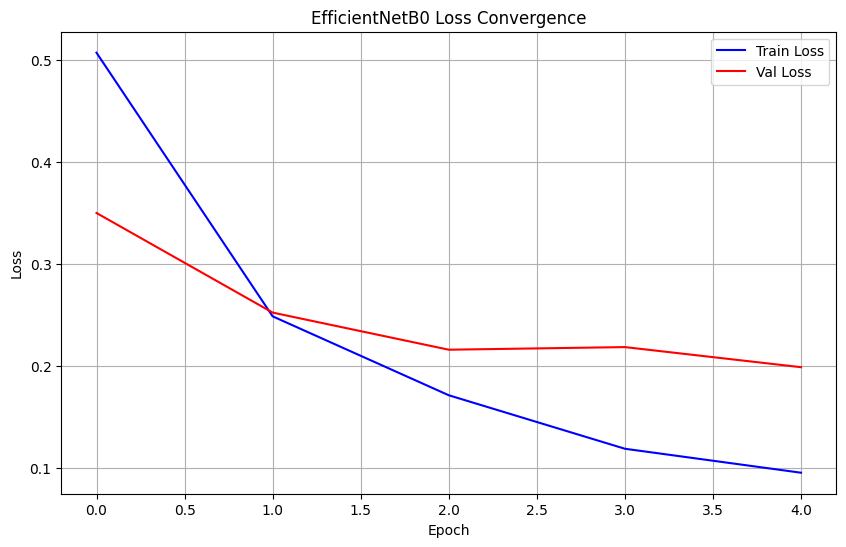

In [43]:
# Define model name
model_name = "efficientnet_b0"

# Prepare dataloaders using model-specific image size
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name,sample_size=1000,batch_size=64)

# Train and evaluate
print("\n===== Training EfficientNetB0 =====")
efficientnet_b0_model = build_model(model_name)
eff0_train_loss, eff0_val_loss = train_model(
    efficientnet_b0_model, train_loader, val_loader, epochs=5
)

plot_loss(eff0_train_loss, eff0_val_loss, "EfficientNetB0 Loss Convergence")

Evaluating the model on the testing set

In [29]:
print("\n===== EfficientNetB0 Evaluation =====")
eff0_metrics = evaluate(efficientnet_b0_model, test_loader,show_cm=False)


===== EfficientNetB0 Evaluation =====

Evaluation Metrics:
Accuracy : 0.9133
Precision: 0.8444
Recall   : 0.8636
F1 Score : 0.8539

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       106
           1       0.84      0.86      0.85        44

    accuracy                           0.91       150
   macro avg       0.89      0.90      0.90       150
weighted avg       0.91      0.91      0.91       150



### 3.Train and Evaluate EfficientNetB0

Next, let's train and evaluate the EfficientNetB4 model using the same approach.

Train dataset size: 700
Validation dataset size: 150
Test dataset size: 150
Classes: ['NRPW', 'RPW']

===== Training EfficientNetB4 =====
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)


Epoch 1/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


[Epoch 1] 🔹 Train Loss: 0.6234 🔸 Val Loss: 0.5687


Epoch 2/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


[Epoch 2] 🔹 Train Loss: 0.5087 🔸 Val Loss: 0.4358


Epoch 3/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


[Epoch 3] 🔹 Train Loss: 0.4144 🔸 Val Loss: 0.3533


Epoch 4/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


[Epoch 4] 🔹 Train Loss: 0.3643 🔸 Val Loss: 0.3505


Epoch 5/5 - Validation: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


[Epoch 5] 🔹 Train Loss: 0.3366 🔸 Val Loss: 0.3204


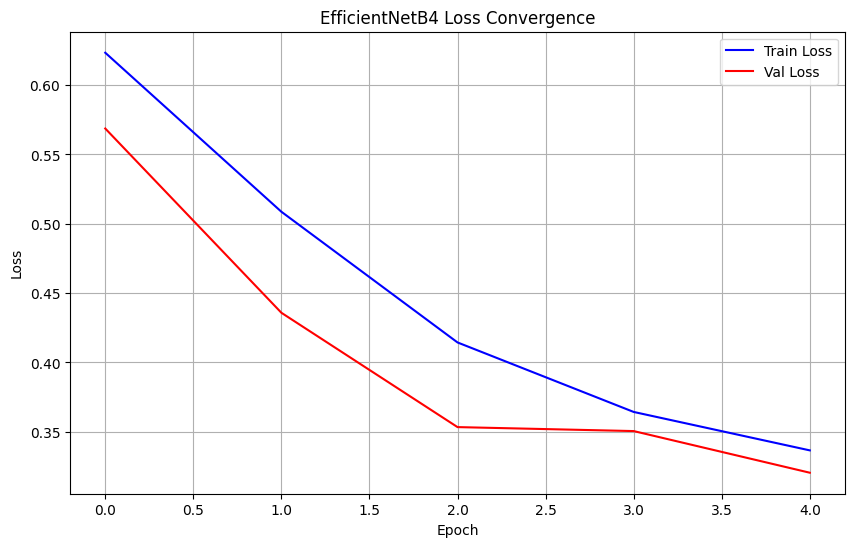

In [44]:
# Define model name
model_name = "efficientnet_b4"

# Prepare dataloaders using model-specific image size
train_loader, val_loader, test_loader, class_names = prepare_dataloaders(model_name,sample_size=1000,batch_size=64)

# Train and evaluate
print("\n===== Training EfficientNetB4 =====")
efficientnet_b4_model = build_model(model_name)
eff4_train_loss, eff4_val_loss = train_model(
    efficientnet_b4_model, train_loader, val_loader, epochs=5
)

plot_loss(eff4_train_loss, eff4_val_loss, "EfficientNetB4 Loss Convergence")

Evaluating the model on the testing set

In [37]:
print("\n===== EfficientNetB4 Evaluation =====")
eff4_metrics = evaluate(efficientnet_b4_model, test_loader,show_cm=False)


===== EfficientNetB4 Evaluation =====

Evaluation Metrics:
Accuracy : 0.8600
Precision: 0.8000
Recall   : 0.7843
F1 Score : 0.7921

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89        99
           1       0.80      0.78      0.79        51

    accuracy                           0.86       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.86      0.86      0.86       150



## 6- Model Comparison

Finally, let's compare the performance of both models side by side.

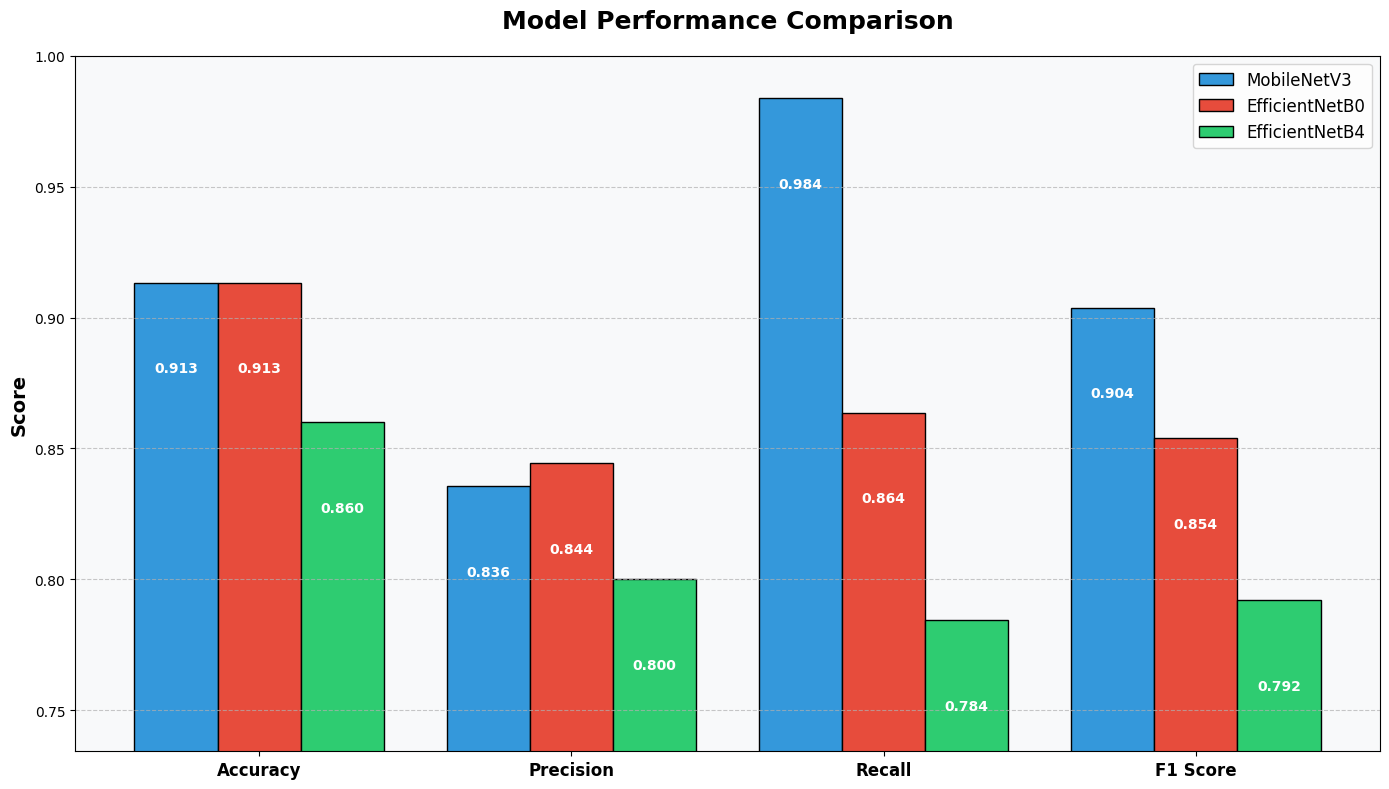

In [38]:
# Step 2: Organize metrics into a dictionary
model_metrics = {
    "MobileNetV3": list(mobile_metrics),
    "EfficientNetB0": list(eff0_metrics),
    "EfficientNetB4": list(eff4_metrics),
}


# Step 3: Define plotting function
def plot_model_comparison(model_metrics):
    import numpy as np
    import matplotlib.pyplot as plt

    metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    models = list(model_metrics.keys())
    values = [model_metrics[m] for m in models]

    num_metrics = len(metrics_names)
    num_models = len(models)
    x = np.arange(num_metrics)
    width = 0.8 / num_models  # Keep bars within group

    plt.figure(figsize=(14, 8))

    # Custom color palette
    colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12", "#9b59b6", "#1abc9c"]

    # Plot each model's bars
    for i, (model_name, scores) in enumerate(model_metrics.items()):
        offset = (i - num_models / 2) * width + width / 2
        plt.bar(
            x + offset,
            scores,
            width,
            label=model_name,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=1,
        )

        # Add value labels
        for j, score in enumerate(scores):
            plt.text(
                x[j] + offset,
                score - 0.03,
                f"{score:.3f}",
                ha="center",
                va="top",
                fontsize=10,
                fontweight="bold",
                color="white",
            )

    # Styling
    plt.xticks(x, metrics_names, fontsize=12, fontweight="bold")
    plt.ylabel("Score", fontsize=14, fontweight="bold")
    plt.title("Model Performance Comparison", fontsize=18, fontweight="bold", pad=20)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(max(0, min(min(v) for v in values) - 0.05), 1.0)
    plt.gca().set_facecolor("#f8f9fa")
    plt.tight_layout()
    plt.show()


# Step 4: Plot all together
plot_model_comparison(model_metrics)

In [50]:
# Step 1: Organize loss metrics into a dictionary
loss_metrics = {
    "MobileNetV3": {"train": mobile_train_loss, "val": mobile_val_loss},
    "EfficientNetB0": {"train": eff_train_loss, "val": eff_val_loss},
    "EfficientNetB4": {"train": eff4_train_loss, "val": eff4_val_loss},  # Added EfficientNetB4
}

# Function to plot training loss
def plot_training_loss(loss_metrics):
    plt.figure(figsize=(12, 6))
    
    # Custom color palette for the models
    colors = {
        "MobileNetV3": "#3498db",
        "EfficientNetB0": "#e74c3c",
        "EfficientNetB4": "#2ecc71",  # Color for EfficientNetB4
    }

    # Plot each model's training loss
    for model_name, losses in loss_metrics.items():
        epochs = range(len(losses["train"]))

        plt.plot(
            epochs, 
            losses["train"], 
            label=f"{model_name} Train", 
            color=colors.get(model_name, '#000000'), 
            linewidth=2.5, 
            marker='o', 
            markersize=6
        )

    # Styling for the plot
    plt.title("Training Loss Comparison", fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=14, fontweight='bold')
    plt.ylabel("Loss", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=1, edgecolor='gray', loc='upper right')
    plt.tight_layout()
    plt.show()

# Function to plot validation loss
def plot_validation_loss(loss_metrics):
    plt.figure(figsize=(12, 6))

    # Custom color palette for the models
    colors = {
        "MobileNetV3": "#3498db",
        "EfficientNetB0": "#e74c3c",
        "EfficientNetB4": "#2ecc71",  # Color for EfficientNetB4
    }

    # Plot each model's validation loss
    for model_name, losses in loss_metrics.items():
        epochs = range(len(losses["val"]))

        plt.plot(
            epochs, 
            losses["val"], 
            label=f"{model_name} Val", 
            color=colors.get(model_name, '#000000'), 
            linewidth=2.5, 
            linestyle='--', 
            marker='o', 
            markersize=6
        )

    # Styling for the plot
    plt.title("Validation Loss Comparison", fontsize=18, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=14, fontweight='bold')
    plt.ylabel("Loss", fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=1, edgecolor='gray', loc='upper right')
    plt.tight_layout()
    plt.show()



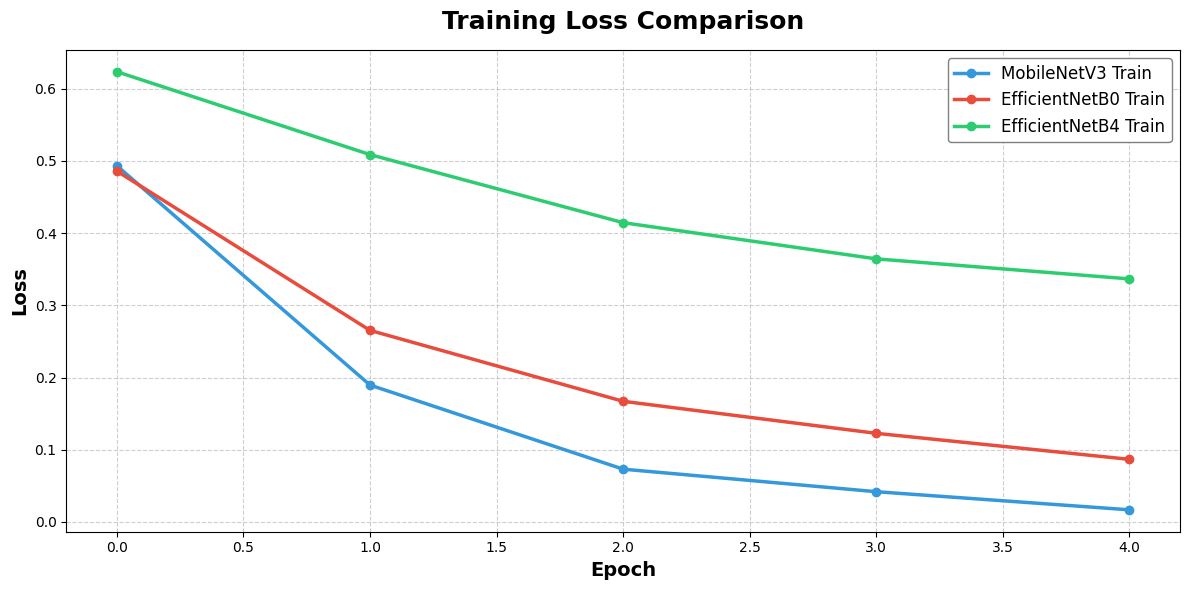

In [51]:

plot_training_loss(loss_metrics)


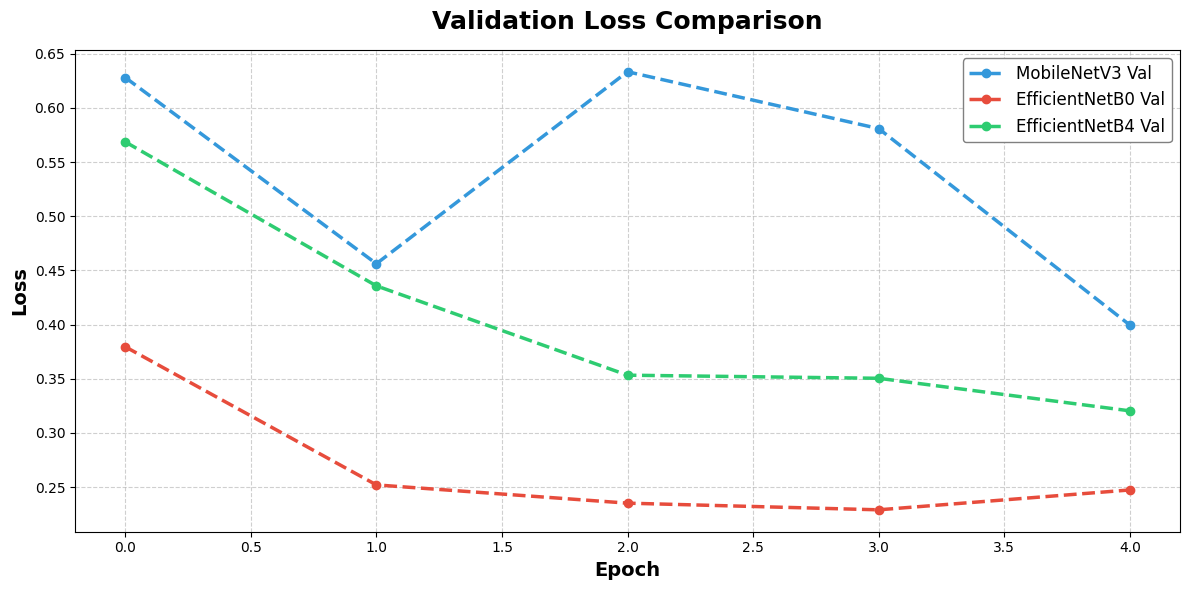

In [52]:

# To plot validation loss:
plot_validation_loss(loss_metrics)


## Save Models

Let's save our trained models for future use.

In [ ]:
# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Save models
torch.save(mobilenet_model.state_dict(), 'saved_models/mobilenetv3_rpw.pth')
torch.save(efficientnet_model.state_dict(), 'saved_models/efficientnetb0_rpw.pth')

print("Models saved successfully!")

## Conclusion

In this notebook, we've compared MobileNetV3 and EfficientNetB0 on a custom dataset. Key takeaways:

1. Both models are optimized for mobile/edge devices but have different trade-offs
2. MobileNetV3 typically has faster inference but may sacrifice some accuracy
3. EfficientNetB0 often achieves higher accuracy but with increased computational cost
4. The in-memory dataset approach works well for smaller datasets but may not be suitable for larger ones
5. Partial freezing of layers helps leverage pre-trained weights while adapting to our specific task

For real-world deployment, consider:
- Model quantization for further optimization
- More sophisticated data augmentation techniques
- Hyperparameter tuning (learning rate, batch size, etc.)
- Ensemble methods for potentially higher accuracy